# Plotting Posteriors!

In [29]:
from julia import Julia
jl = Julia(sysimage = "/home/callum/ASF/Fitting/sys_model.so") #loading sys image

In [30]:
import matplotlib.pyplot as plt

import os
import tempfile
import numpy as np
import scipy as sp

from scipy import stats
import random as rd
from brokenaxes import brokenaxes
from matplotlib.gridspec import GridSpec

In [31]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica",
    "font.size": 10
})
plt.style.use('seaborn-colorblind')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

In [37]:
def read_inputs(path,number):
    
    models = [1,2,3,4]
    
    if number not in models:
        raise Exception("Model number must be 1, 2, 3 or 4") 
        
    weights = np.genfromtxt(path + "/H{}_weights.csv".format(number), delimiter=',')
    params = np.genfromtxt(path + "/H{}_params.csv".format(number), delimiter=',')
    
    nparams = params.shape[1]
    
    p1_dis = stats.gaussian_kde(params[:,0],weights = weights)
    p2_dis = stats.gaussian_kde(params[:,1],weights = weights)
    
    if nparams == 2:
        return p1_dis, p2_dis
    elif nparams == 3:
        p3_dis = stats.gaussian_kde(params[:,2],weights = weights)
        return p1_dis, p2_dis, p3_dis
    

In [33]:
def run_simulations(path,number,n_sims, median = False, distance = False):
    
    posteriors = read_inputs(path,number)
    
    n_params = len(posteriors) #two or three fitted parameters!
    
    store  = np.zeros((n_sims,3))
    
    dd = 0
    n_samples = 100000
    
    dp1 = posteriors[0].resample(n_samples)[0]
    dp2 = posteriors[1].resample(n_samples)[0]

    rd.shuffle(dp1)
    rd.shuffle(dp2)
    
    if n_params == 3:
        dp3 = posteriors[2].resample(n_samples)[0]
        rd.shuffle(dp3)
        
    if median:
        if n_params == 2:
            p = {"p1":np.median(dp1),"p2":np.median(dp2)}
        elif n_params ==3:
            p = {"p1":np.median(dp1),"p2":np.median(dp2), "p3":np.median(dp3)}
            
    for i in range(n_sims):
        
        if not median:
            if n_params == 2:
                p = {"p1":dp1[i],"p2":dp2[i]}
            elif n_params ==3:
                p = {"p1":dp1[i],"p2":dp2[i], "p3":dp3[i]}

        
        
        if number == 1:
            out = model1(p)
            
        elif number == 2:
             out = model2(p)
                
        elif number == 3:
             out = model3(p)
                
        else:
             out = model4(p)

        
        store[i] = out["SS"][0:3]
        dd += out["SS"][3]
    print("Finished")
    if distance:
        dis, mean, c95 = distance_from_mean(store)
        
        return store, dis, mean, c95
    
    else:        
        return store, dd
    
    
        
        

In [7]:
def distance_from_mean(store):
    
    mean_ep = 1.5
    std_ep = 0.604

    mean_pd = 75
    std_pd = 6.08

    mean_mt = 180
    std_mt = 36.475

    
    store_t = (store -[mean_ep, mean_pd, mean_mt]) / ([std_ep, std_pd, std_mt])
    
    d = np.linalg.norm(store_t,axis=1)
    
    mean = np.mean(d)
    c_95 = np.percentile(d,[2.5, 97.5])
    
    print('Mean distance = ', mean)
    print('95% confidence interval =', c_95)
    
    return d, mean, c_95

In [8]:
#Functions to see how many simulations are withing ALL the 95\% conf of summary stats

def within_95_1(data):
    return len(data[(data[:,0] > 0.5) & (data[:,0]  < 2.5) & (data[:,1] > 65)  & (data[:,1] < 85)])

def within_95_2(data):
    return len(data[(data[:,0] > 0.5) & (data[:,0]  < 2.5) & (data[:,2] > 120)  & (data[:,2] < 240)])

def within_95(data):
    return len(data[(data[:,0] > 0.5) & (data[:,0]  < 2.5) & (data[:,2] > 120)  & (data[:,2] < 240) & (data[:,1] > 65)  & (data[:,1] < 85)])

# ODE


## Posteriors

In [9]:
#Load in fitting results
ode_1p = read_inputs("Posteriors/ODE/", 1)
ode_2p = read_inputs("Posteriors/ODE/", 2)
ode_3p = read_inputs("Posteriors/ODE/", 3)
ode_4p = read_inputs("Posteriors/ODE/", 4)

In [10]:
lode_1p = read_inputs("Posteriors/ODE/", 1)
lode_2p = read_inputs("Posteriors/ODE/", 2)
lode_3p = read_inputs("Posteriors/ODE/", 3)
lode_4p = read_inputs("Posteriors/ODE/", 4)

#to find stats about posteriors
n_samples = 1000000
lsh1p1= lode_1p[0].resample(n_samples)
lsh2p1= lode_2p[0].resample(n_samples)
lsh3p1= lode_3p[0].resample(n_samples)
lsh4p1= lode_4p[0].resample(n_samples)


lsh1p2= lode_1p[1].resample(n_samples)
lsh2p2= lode_2p[1].resample(n_samples)
lsh3p2= lode_3p[1].resample(n_samples)
lsh4p2= lode_4p[1].resample(n_samples)

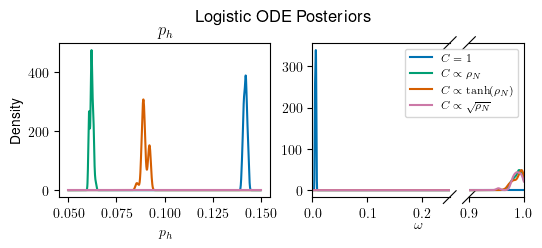

In [11]:
fig = plt.figure(figsize=(6, 2))
sps1, sps2 = GridSpec(1,2)
fig.suptitle('Logistic ODE Posteriors',y=1.05)

x = np.linspace(0.05, 0.15, 1000)

ax1 = fig.add_subplot(sps1)
ax1.plot(x, lode_1p[0].pdf(x), label =  r"$\beta \not \propto \rho$", color = colors[0])
ax1.plot(x, lode_2p[0].pdf(x), label =  r"$\beta \propto \rho$", color = colors[1])
ax1.plot(x, lode_3p[0].pdf(x), label =  r"$\beta \propto \tanh \rho$", color = colors[2])
ax1.plot(x, lode_4p[0].pdf(x), label =  r"$\beta \propto  \sqrt \rho$", color = colors[3])


ax1.set_xlabel(r'$p_h$')
ax1.set_ylabel("Density")
ax1.set_title(r"$p_h$")
#ax1.set_xlim([0,0.2])



bax = brokenaxes(xlims=((0, 0.25), (.9, 1.0)), hspace=.05, subplot_spec=sps2, despine = False)
x = np.linspace(0, 1, 10000)
n_samples = 1000000


bax.plot(x, lode_1p[1].pdf(x), label =  r"$C = 1$", color = colors[0])
bax.plot(x, lode_2p[1].pdf(x), label =  r"$C \propto \rho_N$", color = colors[1])
bax.plot(x, lode_3p[1].pdf(x), label =  r"$C \propto \tanh(\rho_N)$", color = colors[2])
bax.plot(x, lode_4p[1].pdf(x), label =  r"$C \propto  \sqrt {\rho_N}$", color = colors[3])
#bax.axs[0].yaxis.set_major_formatter(EngFormatter())
bax.legend(fontsize=8)
bax.set_xlabel(r'$\omega$')
plt.savefig('logistic_ode_post.pdf', format='pdf', bbox_inches='tight')

In [12]:
#to find stats about posteriors
n_samples = 1000000
sh1p1= ode_1p[0].resample(n_samples)
sh2p1= ode_2p[0].resample(n_samples)
sh3p1= ode_3p[0].resample(n_samples)
sh4p1= ode_4p[0].resample(n_samples)


sh1p2= ode_1p[1].resample(n_samples)
sh2p2= ode_2p[1].resample(n_samples)
sh3p2= ode_3p[1].resample(n_samples)
sh4p2= ode_4p[1].resample(n_samples)

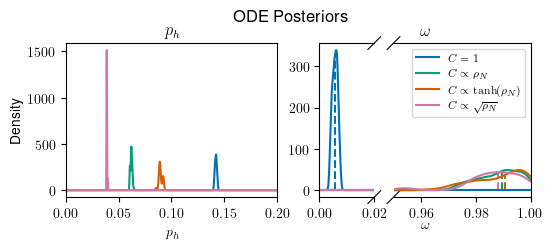

In [13]:
fig = plt.figure(figsize=(6, 2))
sps1, sps2 = GridSpec(1,2)
fig.suptitle('ODE Posteriors',y=1.05)

x = np.linspace(0, 0.2, 1000)

ax1 = fig.add_subplot(sps1)
ax1.plot(x, ode_1p[0].pdf(x), label =  r"$\beta \not \propto \rho$", color = colors[0])
ax1.plot(x, ode_2p[0].pdf(x), label =  r"$\beta \propto \rho$", color = colors[1])
ax1.plot(x, ode_3p[0].pdf(x), label =  r"$\beta \propto \tanh \rho$", color = colors[2])
ax1.plot(x, ode_4p[0].pdf(x), label =  r"$\beta \propto  \sqrt \rho$", color = colors[3])


ax1.set_xlabel(r'$p_h$')
ax1.set_ylabel("Density")
ax1.set_title(r"$p_h$")
ax1.set_xlim([0,0.2])


bax = brokenaxes(xlims=((0, 0.02), (.95, 1.0)), hspace=.05, subplot_spec=sps2, despine = False)
x = np.linspace(0, 1, 10000)
n_samples = 1000000

bax.vlines(np.median(sh1p2), 0, ode_1p[1].pdf(np.median(sh1p2))[0], ls = '--', color = colors[0])
bax.vlines(np.median(sh2p2), 0, ode_2p[1].pdf(np.median(sh2p2))[0], ls = '--', color = colors[1])
bax.vlines(np.median(sh3p2), 0, ode_3p[1].pdf(np.median(sh3p2))[0], ls = '--', color = colors[2])
bax.vlines(np.median(sh4p2), 0, ode_4p[1].pdf(np.median(sh4p2))[0], ls = '--', color = colors[3])


bax.plot(x, ode_1p[1].pdf(x), label =  r"$C = 1$", color = colors[0])
bax.plot(x, ode_2p[1].pdf(x), label =  r"$C \propto \rho_N$", color = colors[1])
bax.plot(x, ode_3p[1].pdf(x), label =  r"$C \propto \tanh (\rho_N)$", color = colors[2])
bax.plot(x, ode_4p[1].pdf(x), label =  r"$C \propto  \sqrt{ \rho_N}$", color = colors[3])
#bax.axs[0].yaxis.set_major_formatter(EngFormatter())
bax.legend(fontsize=8)
bax.set_xlabel(r'$\omega$')

bax.set_title(r"$\omega$")
plt.savefig('ode_post.pdf', format='pdf', bbox_inches='tight')

## Running from Posteriors

In [57]:
#Loading models

jl.eval('push!(LOAD_PATH, "/home/callum/ASF/Fitting/ODE_FIT.jl")')
jl.include('/home/callum/ASF/Fitting/ODE_FIT.jl') #loading files with our model!


#Loading the four models!
model1 = jl.SIR_ODE.model_1 #Frequency
model2 = jl.SIR_ODE.model_2 #Pure Density
model3 = jl.SIR_ODE.model_3 #Sigmoid Density
model4 = jl.SIR_ODE.model_4 #Sqrt Density


In [76]:
jl.eval('push!(LOAD_PATH, "/home/callum/ASF/Fitting/TAU_HOMO_FIT.jl")')
jl.include('/home/callum/ASF/Fitting/TAU_HOMO_FIT.jl') #loading files with our model!
model1 = jl.SIR_TAU_S.model_1 #Frequency
model2 = jl.SIR_TAU_S.model_2 #Pure Density
model3 = jl.SIR_TAU_S.model_3 #Sigmoid Density
model4 = jl.SIR_TAU_S.model_4 #Sqrt Density



/home/callum/.local/lib/python3.10/site-packages/julia/core.py:709: FutureWarning: Accessing `Julia().<name>` to obtain Julia objects is deprecated.  Use `from julia import Main; Main.<name>` or `jl = Julia(); jl.eval('<name>')`.
  warnings.warn(


In [77]:
hi1,hc1 = run_simulations2("Posteriors/Tau-Homogeneous/", 1, 1000)

hi4,hc4= run_simulations2("Posteriors/Tau-Homogeneous/", 4, 1000)

In [75]:
fi1,fc1 = run_simulations2("Posteriors/ODE/", 1, 1000)
#so2,eo2,io2,ro2,co2 = run_simulations2("Posteriors/ODE/", 2, 1000)
#so3,eo3,io3,ro3,co3 = run_simulations2("Posteriors/ODE/", 3, 1000)
fi4,fc4 = run_simulations2("Posteriors/ODE/", 4, 1000)

In [63]:
stats.t.interval(alpha=0.95, df=len(data)-1, loc=np.mean(data), scale=stats.sem(data)) 


(8.418356509796829e-05, 8.688362500899512e-05)

In [47]:
def filter_out(s,e,i,r,c):
    
    inf = e + i + c 
    
    return s[inf[:,-1]>1],  e[inf[:,-1]>1],  i[inf[:,-1]>1],  r[inf[:,-1]>1],  c[inf[:,-1]>1]




In [28]:
#running models
ode_1, ode_1d = run_simulations("Posteriors/ODE/", 1, 10000)
ode_2, ode_2d = run_simulations("Posteriors/ODE/", 2, 10000)
ode_3, ode_3d = run_simulations("Posteriors/ODE/", 3, 10000)
ode_4, ode_4d = run_simulations("Posteriors/ODE/", 4, 10000)



Finished
Finished
Finished
Finished


In [16]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h


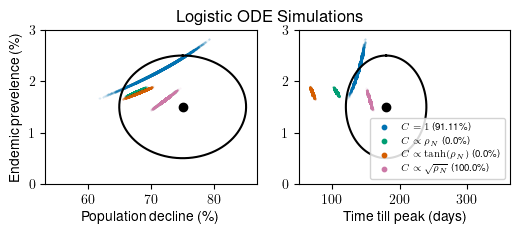

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (6,2))
fig.suptitle('Logistic ODE Simulations')

ax1.scatter(ode_1[:,1], ode_1[:,0], s = 0.2, alpha=0.1, label =  r"$\beta \propto 1$ ({}\%)".format(np.round(100*within_95_1(ode_1)/len(ode_1),3)))
ax1.scatter(ode_2[:,1], ode_2[:,0], s = 0.2, alpha=0.1, label =  r"$\beta \propto \rho$ ({}\%)".format(np.round(100*within_95_1(ode_2)/len(ode_1),3)))
ax1.scatter(ode_3[:,1], ode_3[:,0], s = 0.2, alpha=0.1, label =  r"$\beta \propto \tanh(\rho)$ ({}\%)".format(np.round(100*within_95_1(ode_3)/len(ode_1),3)))
ax1.scatter(ode_4[:,1], ode_4[:,0], s = 0.2, alpha=0.1, label =  r"$\beta \propto \sqrt\rho$ ({}\%)".format(np.round(100*within_95_1(ode_4)/len(ode_1),3)))
    
u=1.5     #x-position of the center
v=75    #y-position of the center
a=1    #radius on the x-axis
b=10    #radius on the y-axis

ax1.plot(v,u,"ko")
t = np.linspace(0, 2*np.pi, 100)
ax1.plot( v+b*np.sin(t), u+a*np.cos(t) ,"k" )


ax2.scatter(ode_1[:,2], ode_1[:,0], s = 0.2, alpha=0.1, label =  r"$C = 1$ ({}\%)".format(np.round(100*within_95(ode_1)/len(ode_1),3)))
ax2.scatter(ode_2[:,2], ode_2[:,0], s = 0.2, alpha=0.1, label =  r"$C \propto \rho_N$ ({}\%)".format(np.round(100*within_95(ode_2)/len(ode_1),3)))
ax2.scatter(ode_3[:,2], ode_3[:,0], s = 0.2, alpha=0.1, label =  r"$C \propto \tanh(\rho_N) $ ({}\%)".format(np.round(100*within_95(ode_3)/len(ode_1),3)))
ax2.scatter(ode_4[:,2], ode_4[:,0], s = 0.2, alpha=0.1, label =  r"$C \propto \sqrt{ \rho_N }$"+" ({}\%)".format(np.round(100*within_95(ode_4)/len(ode_1),3)))

ax1.set_xlim([53.33,86.66])
ax1.set_ylim([0,3])

ax2.set_xlim([50,365])
ax2.set_ylim([0,3])

v = 180
b = 60

ax2.plot(v,u,"ko")
ax2.plot( v+b*np.sin(t), u+a*np.cos(t) ,"k" )

ax1.set_ylabel("Endemic prevelence (\%)")
ax1.set_xlabel("Population decline (\%)")
ax2.set_xlabel("Time till peak (days)")

lgnd = ax2.legend(loc=4, numpoints=1, fontsize=7,  framealpha=0.85)

for handle in lgnd.legendHandles:
    handle.set_sizes([10.0])
    handle.set_alpha(1)
    


#plt.savefig('logistic_ode_sims.pdf', format='pdf', bbox_inches='tight')

# TAU Homogeneous

## Posteriors

In [ ]:
tau_1_p = read_inputs("Posteriors/Tau-Homogeneous/", 1)
tau_2_p = read_inputs("Posteriors/Tau-Homogeneous/", 2)
tau_3_p = read_inputs("Posteriors/Tau-Homogeneous/", 3)
tau_4_p = read_inputs("Posteriors/Tau-Homogeneous/", 4)

In [ ]:
ep1 = np.linspace(0.025, 0.2, 1000)
ep2 = np.linspace(0, 1, 1000)

n_samples = 10000
shh1p1= tau_1_p[0].resample(n_samples)
shh2p1= tau_2_p[0].resample(n_samples)
shh3p1= tau_3_p[0].resample(n_samples)
shh4p1= tau_4_p[0].resample(n_samples)

shh1p2= tau_1_p[1].resample(n_samples)
shh2p2= tau_2_p[1].resample(n_samples)
shh3p2= tau_3_p[1].resample(n_samples)
shh4p2= tau_4_p[1].resample(n_samples)

In [ ]:
from scipy.stats import mode

In [ ]:
def print_stats(data):
    n_samples = 1000000
    ep = np.linspace(0,1,n_samples)
    
    for i in data:
        
        rs = i.resample(n_samples)
        rm = i.pdf(ep)
        
        print("MAP:, ", np.round(ep[np.argmax(rm)],3))
        print("Mean:, ",  np.round(np.mean(rs),3))
        print("Median: ",  np.round(np.median(rs),3))
        print()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (6,2))
fig.suptitle('Tau-Leaping Homogeneous Posteriors',y=1.07)

ax1.vlines(np.median(shh1p1), 0, tau_1_p[0].pdf(np.median(shh1p1))[0], ls = '--', color = colors[0])
ax1.vlines(np.median(shh2p1), 0, tau_2_p[0].pdf(np.median(shh2p1))[0], ls = '--', color = colors[1])
ax1.vlines(np.median(shh3p1), 0, tau_3_p[0].pdf(np.median(shh3p1))[0], ls = '--', color = colors[2])
ax1.vlines(np.median(shh4p1), 0, tau_4_p[0].pdf(np.median(shh4p1))[0], ls = '--', color = colors[3])

ax1.plot(ep1, tau_1_p[0].pdf(ep1), label =  r"$\beta \not \propto \rho$", color = colors[0])
ax1.plot(ep1, tau_2_p[0].pdf(ep1), label =  r"$\beta \propto  \sqrt \rho$", color = colors[1])
ax1.plot(ep1, tau_3_p[0].pdf(ep1), label =  r"$\beta \propto  \sqrt \rho$", color = colors[2])
ax1.plot(ep1, tau_4_p[0].pdf(ep1), label =  r"$\beta \propto  \sqrt \rho$", color = colors[3])

ax1.set_title(r"$\beta_h$")
ax1.set_xlabel(r"$\beta_h$")
ax1.set_ylabel("Density")


ax2.vlines(np.median(shh1p2), 0, tau_1_p[1].pdf(np.median(shh1p2))[0], ls = '--', color = colors[0])
ax2.vlines(np.median(shh2p2), 0, tau_2_p[1].pdf(np.median(shh2p2))[0], ls = '--', color = colors[1])
ax2.vlines(np.median(shh3p2), 0, tau_3_p[1].pdf(np.median(shh3p2))[0], ls = '--', color = colors[2])
ax2.vlines(np.median(shh4p2), 0, tau_4_p[1].pdf(np.median(shh4p2))[0], ls = '--', color = colors[3])

ax2.plot(ep2, tau_1_p[1].pdf(ep2), label =  r"$\beta \propto 1$", color = colors[0])
ax2.plot(ep2, tau_2_p[1].pdf(ep2), label =  r"$\beta \propto \rho$", color = colors[1])
ax2.plot(ep2, tau_3_p[1].pdf(ep2), label =  r"$\beta \propto \tanh (\rho)$", color = colors[2])
ax2.plot(ep2, tau_4_p[1].pdf(ep2), label =  r"$\beta \propto  \sqrt \rho$", color = colors[3])

ax2.set_title(r"$\omega$")
ax2.set_xlabel(r"$\omega$")

ax2.legend(fontsize=8)
plt.savefig('tau_homogeneous_post.pdf', format='pdf', bbox_inches='tight')

## Running from Posteriors

In [ ]:
jl.eval('push!(LOAD_PATH, "/home/callum/ASF/Fitting/TAU_HOMO_FIT.jl")')
jl.include('/home/callum/ASF/Fitting/TAU_HOMO_FIT.jl') #loading files with our model!
model1 = jl.SIR_TAU_S.model_1 #Frequency
model2 = jl.SIR_TAU_S.model_2 #Pure Density
model3 = jl.SIR_TAU_S.model_3 #Sigmoid Density
model4 = jl.SIR_TAU_S.model_4 #Sqrt Density



In [ ]:
tauho_1, d1 = run_simulations("Posteriors/Tau-Homogeneous/", 1, 10000)
tauho_2, d2 = run_simulations("Posteriors/Tau-Homogeneous/", 2, 10000)
tauho_3, d3 = run_simulations("Posteriors/Tau-Homogeneous/", 3, 10000)
tauho_4, d4 = run_simulations("Posteriors/Tau-Homogeneous/", 4, 10000)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (6,2))
fig.suptitle('Tau-Leaping Homogeneous Simulations')


ax1.scatter(tauho_1f[:,1], tauho_1f[:,0], s = 0.2, alpha=0.1, label =  r"$\beta \propto 1$ ({}\% endemic)".format(round(100*d1/len(tauho_1),1)), color = colors[0])
ax1.scatter(tauho_2f[:,1], tauho_2f[:,0], s = 0.2, alpha=0.1, label =  r"$\beta \propto 1$ ({}\% endemic)".format(round(100*d1/len(tauho_1),1)), color = colors[1])
ax1.scatter(tauho_3f[:,1], tauho_3f[:,0], s = 0.2, alpha=0.1, label =  r"$\beta \propto \sqrt \rho$ ({}\% endemic)".format(round(100*d4/len(tauho_4),1)),color=colors[2]) 
ax1.scatter(tauho_4f[:,1], tauho_4f[:,0], s = 0.2, alpha=0.1, label =  r"$\beta \propto \sqrt \rho$ ({}\% endemic)".format(round(100*d4/len(tauho_4),1)),color = colors[3])
    
u=1.5     #x-position of the center
v=75    #y-position of the center
a=1    #radius on the x-axis
b=10    #radius on the y-axis

ax1.plot(v,u,"ko")
t = np.linspace(0, 2*np.pi, 100)
ax1.plot( v+b*np.sin(t), u+a*np.cos(t) ,"k" )


ax2.scatter(tauho_1f[:,2], tauho_1f[:,0], s = 0.2, alpha=0.1, label =  r"$C \propto 1$ ({}\%)".format(np.round(100*within_95(tauho_1)/len(tauho_1),3)), color = colors[0])
ax2.scatter(tauho_2f[:,2], tauho_2f[:,0], s = 0.2, alpha=0.1, label =  r"$C \propto \rho_N$ ({}\%)".format(np.round(100*within_95(tauho_2)/len(tauho_1),3)), color = colors[1])
ax2.scatter(tauho_3f[:,2], tauho_3f[:,0], s = 0.2, alpha=0.1, label =  r"$C \propto \tanh( \rho_N$) ({}\%)".format(np.round(100*within_95(tauho_3)/len(tauho_1),3)),color = colors[2])
ax2.scatter(tauho_4f[:,2], tauho_4f[:,0], s = 0.2, alpha=0.1, label =  r"$C \propto \sqrt{\rho_N}$"+" ({}\%)".format(np.round(100*within_95(tauho_4)/len(tauho_1),3)),color = colors[3])
v = 180
b = 60

ax2.plot(v,u,"ko")
ax2.plot( v+b*np.sin(t), u+a*np.cos(t) ,"k" )

ax1.set_ylabel("Endemic prevelence (\%)")
ax1.set_xlabel("Population decline (\%)")
ax2.set_xlabel("Time till peak (days)")

lgnd = ax2.legend(loc=1, numpoints=1, fontsize=8)

for handle in lgnd.legendHandles:
    handle.set_sizes([10.0])
    handle.set_alpha(1)
ax2.set_xlim([0,3*365])    


# Tau Hetrogeneous

## Posteriors

In [ ]:
tau_sf_1_p = read_inputs("Posteriors/Tau-Hetrogeneous/Scale_Free/",1)
tau_sf_4_p = read_inputs("Posteriors/Tau-Hetrogeneous/Scale_Free/",4)

tau_r_1_p = read_inputs("Posteriors/Tau-Hetrogeneous/Random/",1)
tau_r_4_p = read_inputs("Posteriors/Tau-Hetrogeneous/Random/",4)

tau_sw_1_p = read_inputs("Posteriors/Tau-Hetrogeneous/Small_Worlds/",1)
tau_sw_4_p = read_inputs("Posteriors/Tau-Hetrogeneous/Small_Worlds/",4)

In [ ]:
ep1 = np.linspace(0, 1, 1000)
ep2 = np.linspace(0, 0.3, 1000)
ep3 = np.linspace(0, 1, 1000)

n_samples = 1000000

sf1p1= tau_sf_1_p[0].resample(n_samples)
sf4p1= tau_sf_4_p[0].resample(n_samples)

sf1p2= tau_sf_1_p[1].resample(n_samples)
sf4p2= tau_sf_4_p[1].resample(n_samples)

sf1p3= tau_sf_1_p[2].resample(n_samples)
sf4p3= tau_sf_4_p[2].resample(n_samples)

sw1p1= tau_sw_1_p[0].resample(n_samples)
sw4p1= tau_sw_4_p[0].resample(n_samples)

sw1p2= tau_sw_1_p[1].resample(n_samples)
sw4p2= tau_sw_4_p[1].resample(n_samples)

sw1p3= tau_sw_1_p[2].resample(n_samples)
sw4p3= tau_sw_4_p[2].resample(n_samples)

r1p1= tau_r_1_p[0].resample(n_samples)
r4p1= tau_r_4_p[0].resample(n_samples)

r1p2= tau_r_1_p[1].resample(n_samples)
r4p2= tau_r_4_p[1].resample(n_samples)

r1p3= tau_r_1_p[2].resample(n_samples)
r4p3= tau_r_4_p[2].resample(n_samples)


In [26]:
jl.eval('push!(LOAD_PATH, "/home/callum/ASF/Fitting/TAU_HETRO_FIT.jl")')
jl.include('/home/callum/ASF/Fitting/TAU_HETRO_FIT.jl') #loading files with our model!
model1 = jl.SIR_TAU_M.model_1 #Frequency
model4 = jl.SIR_TAU_M.model_4 #Sqrt Density

In [ ]:
def print_stats(data):
    n_samples = 1000000
    ep = np.linspace(0,1,n_samples)
    
    i = data[1]
        
    rs = i.resample(n_samples)
    rm = i.pdf(ep)
        
    print("MAP:, ", np.round(ep[np.argmax(rm)]/6,4))
    print("Mean:, ",  np.round(np.mean(rs)/6,4))
    print("Median: ",  np.round(np.median(rs)/6,4))
    print()

In [ ]:
fig = plt.figure(figsize=(6,8))

gs = GridSpec(3, 2, figure=fig, hspace=.5)
plt.suptitle("Tau-Leaping Heterogeneous Posteriors", y=0.94)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[2, 0])
ax6 = fig.add_subplot(gs[2, 1])


ax1.plot(ep1, tau_r_1_p[0].pdf(ep1), label =  r"Random", color = colors[0])
ax1.plot(ep1, tau_sf_1_p[0].pdf(ep1), label =  r"Scale Free", color = colors[0], ls = '--')
ax1.plot(ep1, tau_sw_1_p[0].pdf(ep1), label =  r"Small Worlds", color = colors[0], ls = ":")

ax2.plot(ep1, tau_r_4_p[0].pdf(ep1), label =  r"Random", color = colors[3])
ax2.plot(ep1, tau_sf_4_p[0].pdf(ep1), label =  r"Scale Free", color = colors[3], ls = '--')
ax2.plot(ep1, tau_sw_4_p[0].pdf(ep1), label =  r"Small Worlds", color = colors[3], ls=":")

ax3.plot(ep2/6, tau_r_1_p[1].pdf(ep2), label =  r"Random", color = colors[0])
ax3.plot(ep2/6, tau_sf_1_p[1].pdf(ep2), label =  r"Scale Free", color = colors[0], ls = '--')
ax3.plot(ep2/6, tau_sw_1_p[1].pdf(ep2), label =  r"Small World", color = colors[0], ls = ":")

ax3.legend(fontsize=8)

ax4.plot(ep2/6, tau_r_4_p[1].pdf(ep2), label =  r"Random", color = colors[3])
ax4.plot(ep2/6, tau_sf_4_p[1].pdf(ep2), label =  r"Scale Free", color = colors[3], ls = '--')
ax4.plot(ep2/6, tau_sw_4_p[1].pdf(ep2), label =  r"Small World", color = colors[3], ls=":")

ax4.legend(fontsize=8)


ax5.plot(ep3, tau_r_1_p[2].pdf(ep3), label =  r"Random", color = colors[0])
ax5.plot(ep3, tau_sf_1_p[2].pdf(ep3), label =  r"Scale Free", color = colors[0], ls = '--')
ax5.plot(ep3, tau_sw_1_p[2].pdf(ep3), label =  r"Small World", color = colors[0], ls = ":")

ax6.plot(ep3, tau_r_4_p[2].pdf(ep3), label =  r"Random", color = colors[3])
ax6.plot(ep3, tau_sf_4_p[2].pdf(ep3), label =  r"Scale Free", color = colors[3], ls = '--')
ax6.plot(ep3, tau_sw_4_p[2].pdf(ep3), label =  r"Small World", color = colors[3], ls=":")

ax1.set_ylabel("Density")
ax3.set_ylabel("Density")
ax5.set_ylabel("Density")

ax1.set_xlabel(r"$p_{i}$")
ax2.set_xlabel(r"$p_{i}$")

ax3.set_xlabel(r"$p_{o}$")
ax4.set_xlabel(r"$p_{o}$")


ax5.set_xlabel(r"$\omega$")
ax6.set_xlabel(r"$\omega$")

ax1.set_title(r"$\bf{C = 1}$: $p_{i}$")
ax3.set_title(r"$\bf{C = 1}$: $p_{o}$")
ax5.set_title(r"$\bf{C = 1}\propto 1$: $\omega$")

ax2.set_title(r"$\bf{C \propto \sqrt{ \rho_N}}$: $p_{i}$")
ax4.set_title(r"$\bf{C \propto \sqrt{ \rho_N}}$: $p_{o}$")
ax6.set_title(r"$\bf{C \propto \sqrt{ \rho_N}}$: $\omega$")



#plt.savefig('tau_hetrogeneous_post.pdf', format='pdf', bbox_inches='tight')

## Running from posteriors

As running from postiors with this model is far slower than the previous, will load previsouly done runs!

In [ ]:
#jl.eval('push!(LOAD_PATH, "/home/callum/ASF/Fitting/TAU_HETRO_FIT.jl")')
#jl.include('/home/callum/ASF/Fitting/TAU_HETRO_FIT.jl') #loading files with our model!
#model1= jl.SIR_TAU_M.model_1 #Frequency
#model4 = jl.SIR_TAU_M.model_4 #Sqrt Density

#tausf_1, sfd1 = run_simulations("Posteriors/Tau-Hetrogeneous/Scale_Free/", 1, 250)
#tausf_4, sfd4 = run_simulations("Posteriors/Tau-Hetrogeneous/Scale_Free/", 4, 250)

In [ ]:
rn1 = np.load("/home/callum/ASF/Model_Output/Hetrogeneous/out_random_model1.npy")
rn4 = np.load("/home/callum/ASF/Model_Output/Hetrogeneous/out_random_model4.npy")

sw1 = np.load("/home/callum/ASF/Model_Output/Hetrogeneous/out_small_world_model1.npy")
sw4 = np.load("/home/callum/ASF/Model_Output/Hetrogeneous/out_small_world_model4.npy")

sf1 = np.load("/home/callum/ASF/Model_Output/Hetrogeneous/out_scale_free_model1.npy")
sf4 = np.load("/home/callum/ASF/Model_Output/Hetrogeneous/out_scale_free_model4.npy")

In [ ]:
rn1f = rn1[rn1[:,0] > 0 ]
rn4f = rn4[rn4[:,0] > 0 ]

sw1f = sw1[sw1[:,0] > 0 ]
sw4f = sw4[sw4[:,0] > 0 ]

sf1f = sf1[sf1[:,0] > 0 ]
sf4f = sf4[sf4[:,0] > 0 ]

In [ ]:
fig = plt.figure(figsize=(6,8))

gs = GridSpec(3, 2, figure=fig, hspace=.5)
plt.suptitle("Tau-Leaping Heterogeneous Simulations", y=0.94)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[2, 0])
ax6 = fig.add_subplot(gs[2, 1])

ax1.scatter(rn1f[:,1], rn1f[:,0], s = 1, alpha=0.25, color = colors[0])
ax1.scatter(rn4f[:,1], rn4f[:,0], s = 1, alpha=0.25, color = colors[3])
    
u=1.5     #x-position of the center
v=75    #y-position of the center
a=1    #radius on the x-axis
b=10    #radius on the y-axis

ax1.plot(v,u,"ko")
t = np.linspace(0, 2*np.pi, 100)
ax1.plot( v+b*np.sin(t), u+a*np.cos(t) ,"k" )


ax2.scatter(rn1f[:,2], rn1f[:,0], s = 1, alpha=0.25, label =  r"$C = 1$ ({}\%)".format(np.round(100*within_95(rn1)/len(rn1),3)), color = colors[0])
ax2.scatter(rn4f[:,2], rn4f[:,0], s = 1, alpha=0.25, label =  r"$C \propto \sqrt{ \rho_N}$ "+"({}\%)".format(np.round(100*within_95(rn4)/len(rn4),3)),color = colors[3])
v = 180
b = 60

ax2.plot(v,u,"ko")
ax2.plot( v+b*np.sin(t), u+a*np.cos(t) ,"k" )

ax1.set_ylabel("Endemic prevelence (\%)")
ax1.set_xlabel("Population decline (\%)")
ax2.set_xlabel("Time till peak (days)")

ax1.set_title("Random Network (S1+S2)")
ax2.set_title("Random Network (S1+S3)")

lgnd = ax2.legend(loc=1, numpoints=1, fontsize=8)

for handle in lgnd.legendHandles:
    handle.set_sizes([10.0])
    handle.set_alpha(1)



ax3.scatter(sf1f[:,1], sf1f[:,0], s = 1, alpha=0.25, color = colors[0])
ax3.scatter(sf4f[:,1], sf4f[:,0], s = 1, alpha=0.25, color = colors[3])
    
u=1.5     #x-position of the center
v=75    #y-position of the center
a=1    #radius on the x-axis
b=10    #radius on the y-axis

ax3.plot(v,u,"ko")
t = np.linspace(0, 2*np.pi, 100)
ax3.plot( v+b*np.sin(t), u+a*np.cos(t) ,"k" )


ax4.scatter(sf1f[:,2], sf1f[:,0], s = 1, alpha=0.25, label =  r"$C = 1$ ({}\%)".format(np.round(100*within_95(sf1)/len(sf1),3)), color = colors[0])
ax4.scatter(sf4f[:,2], sf4f[:,0], s = 1, alpha=0.25, label =  r"$C \propto \sqrt{ \rho_N}$ "+"({}\%)".format(np.round(100*within_95(sf4)/len(sf4),3)),color = colors[3])
v = 180
b = 60

ax4.plot(v,u,"ko")
ax4.plot( v+b*np.sin(t), u+a*np.cos(t) ,"k" )

ax3.set_ylabel("Endemic prevelence (\%)")
ax3.set_xlabel("Population decline (\%)")
ax4.set_xlabel("Time till peak (days)")

ax3.set_title("Scale-Free Network (S1+S2)")
ax4.set_title("Scale-Free Network (S1+S3)")

lgnd = ax4.legend(loc=1, numpoints=1, fontsize=8)

for handle in lgnd.legendHandles:
    handle.set_sizes([10.0])
    handle.set_alpha(1)
    
    
ax5.scatter(sw1f[:,1], sw1f[:,0], s = 1, alpha=0.25, color = colors[0])
ax5.scatter(sw4f[:,1], sw4f[:,0], s = 1, alpha=0.25, color = colors[3])
    
u=1.5     #x-position of the center
v=75    #y-position of the center
a=1    #radius on the x-axis
b=10    #radius on the y-axis

ax5.plot(v,u,"ko")
t = np.linspace(0, 2*np.pi, 100)
ax5.plot( v+b*np.sin(t), u+a*np.cos(t) ,"k" )


ax6.scatter(sw1f[:,2], sw1f[:,0], s = 1, alpha=0.25, label =  r"$C = 1$ ({}\%)".format(np.round(100*within_95(sw1)/len(sw1),3)), color = colors[0])
ax6.scatter(sw4f[:,2], sw4f[:,0], s = 1, alpha=0.25, label =  r"$C \propto \sqrt{ \rho_N}$"+" ({}\%)".format(np.round(100*within_95(sw4)/len(sw4),3)),color = colors[3])
v = 180
b = 60

ax6.plot(v,u,"ko")
ax6.plot( v+b*np.sin(t), u+a*np.cos(t) ,"k" )

ax5.set_ylabel("Endemic prevelence (\%)")
ax5.set_xlabel("Population decline (\%)")
ax6.set_xlabel("Time till peak (days)")

ax5.set_title("Small-World Network (S1+S2)")
ax6.set_title("Small-World Network (S1+S3)")

lgnd = ax6.legend(loc=1, numpoints=1, fontsize=8)

for handle in lgnd.legendHandles:
    handle.set_sizes([10.0])
    handle.set_alpha(1)
    
plt.savefig('het_sims.pdf', format='pdf', bbox_inches='tight')